# Investment Strategy

In [2]:
#IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(font_scale=1.15)
import warnings; warnings.filterwarnings('ignore')
from IPython.display import Markdown, display, SVG
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegressionCV, RidgeCV, LassoCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor
# from graphviz import Source
pd.options.display.max_rows = 50
pd.options.display.max_columns = 50
pd.options.display.float_format = '{:.3f}'.format
plt.rcParams['figure.figsize'] = (12, 4)

In [3]:
#LOAD LOANSTATS
directory = '../../data/clean/'
ls = pd.read_hdf(directory + 'ls_CLEAN.h5', 'ls_CLEAN')
ls.sort_index(axis=1, inplace=True)

In [4]:
def model_scoring(model, feature, target, modeltype='C', cv=5):
    """Displays model evaluation for regression and classification modeling"""
    scores = ['accuracy', 'precision', 'recall']
    if modeltype=='R': # regression
        scores = ['neg_mean_squared_error', 'r2']
    for score in scores:
        cv_score = cross_val_score(model, feature, target, scoring=score, cv=cv).mean()
        print('\tCross-validation {}: {:.4}'.format(score, cv_score))

In [5]:
from sklearn.model_selection import train_test_split
ls_train, ls_test = train_test_split(ls, test_size=0.2, stratify=ls['OUT_Class'], random_state=1)

In [6]:
#STANDARD SCALING
scaler = StandardScaler()

#separate features and targets
outcome_var_list = sorted(out_var for out_var in ls.columns if "OUT_" in out_var)

#train features
X_train = ls_train[sorted(set(ls.columns)-set(outcome_var_list))]
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train),index=X_train.index, columns=X_train.columns)

#test features
X_test = ls_test[sorted(set(ls.columns)-set(outcome_var_list))]
X_test_scaled = pd.DataFrame(scaler.transform(X_test),index=X_test.index, columns=X_test.columns)

#train targets
y_train = ls_train[sorted(outcome_var_list)]
OUT_Class_train = y_train.iloc[:,0]
OUT_Principle_Repaid_Percentage_train = y_train.iloc[:,1]
OUT_Monthly_Rate_Of_Return_train = y_train.iloc[:,2]

#test targets
y_test = ls_test[sorted(outcome_var_list)]
OUT_Class_test = y_test.iloc[:,0]
OUT_Principle_Repaid_Percentage_test = y_test.iloc[:,1]
OUT_Monthly_Rate_Of_Return_test = y_test.iloc[:,2]

In [7]:
#GET POLYNOMIALS
dummy_var_list = sorted(dummy for dummy in ls.columns if "D_" in dummy)
numeric_var_list = sorted(set(ls.columns) - set(outcome_var_list) - set(dummy_var_list))
poly_2 = pd.DataFrame(np.hstack((X_train.iloc[:,22:]**(i+1) for i in range(2))),
                      index=X_train.index, 
                      columns=numeric_var_list+[s+'_2' for s in numeric_var_list])
X_train_2 = pd.concat([ls_train[dummy_var_list], poly_2], axis=1).sort_index(axis=1)
poly_2 = pd.DataFrame(np.hstack((X_test.iloc[:,22:]**(i+1) for i in range(2))),
                      index=X_test.index, 
                      columns=numeric_var_list+[s+'_2' for s in numeric_var_list])
X_test_2 = pd.concat([ls_test[dummy_var_list], poly_2], axis=1).sort_index(axis=1)

#STANDARD SCALING
scaler = StandardScaler()
X_train_scaled_2 = pd.DataFrame(scaler.fit_transform(X_train_2),index=X_train_2.index, columns=X_train_2.columns)
X_test_scaled_2 = pd.DataFrame(scaler.transform(X_test_2),index=X_test_2.index, columns=X_test_2.columns)

In [8]:
#CLASSIFIERS
dummy_cls = DummyClassifier(strategy='uniform', random_state=1)
dummy_cls.fit(X_train_scaled, OUT_Class_train)
log_cls = LogisticRegressionCV(Cs=8, solver='lbfgs', max_iter=10000, class_weight='balanced', random_state=0, fit_intercept=False)
log_cls.fit(X_train_scaled, OUT_Class_train)

#REGRESSORS PRP
ridge_reg_PRP = RidgeCV(fit_intercept=False)
ridge_reg_PRP.fit(X_train_scaled, OUT_Principle_Repaid_Percentage_train)
lasso_reg_PRP = LassoCV(fit_intercept=False)
lasso_reg_PRP.fit(X_train_scaled, OUT_Principle_Repaid_Percentage_train)
lasso_reg2_PRP = LassoCV(fit_intercept=False)
lasso_reg2_PRP.fit(X_train_scaled_2, OUT_Principle_Repaid_Percentage_train)

#REGRESSORS MRR
ridge_reg_MRR = RidgeCV(fit_intercept=False)
ridge_reg_MRR.fit(X_train_scaled, OUT_Monthly_Rate_Of_Return_train)
lasso_reg_MRR = LassoCV(fit_intercept=False)
lasso_reg_MRR.fit(X_train_scaled, OUT_Monthly_Rate_Of_Return_train)
lasso_reg2_MRR = LassoCV(fit_intercept=False)
lasso_reg2_MRR.fit(X_train_scaled_2,OUT_Monthly_Rate_Of_Return_train)
x=0

## 1. Modeling Summary

In [9]:
results = pd.read_excel(directory + 'ModelResults.xlsx', sheet_name=[0,1,2], header=[0,1])
OUT_Class_results = results[0]
OUT_PRP_results = results[1]
OUT_MRR_results = results[2]

FileNotFoundError: [Errno 2] No such file or directory: '../../data/clean/ModelResults.xlsx'

In the [Modeling](https://cs109group67.github.io/lendingclub/Modeling.html) section we preformed a variety of classifiction and regression models on the three outcome features. A summary of the model scoring metrics is as follows:

In [10]:
display(Markdown('**`OUT_Class`:**'))
OUT_Class_results

**`OUT_Class`:**

NameError: name 'OUT_Class_results' is not defined

In [11]:
display(Markdown('**`OUT_Principle_Repaid`:**'))
OUT_PRP_results

**`OUT_Principle_Repaid`:**

NameError: name 'OUT_PRP_results' is not defined

In [12]:
display(Markdown('**`OUT_Monthly_Rate_Of_Return`:**'))
OUT_MRR_results

**`OUT_Monthly_Rate_Of_Return`:**

NameError: name 'OUT_MRR_results' is not defined

The classification and regression models did not perform well at predicting the target features, but they did provide important information about which variables potentially hold the most inferential information for a prospective investor. The visualizations below display cofficients assigned across the models. The focus is on features that have the most significant magnitude across distinct models.

In [13]:
def plot_coefficients(feature_train, models, title, thresh=(0.0025,4), figsize=(10,4)):
    """Plots the coefficients assigned by the model to each feature"""
    # create DataFrame with coefficient names and values 
    names = feature_train.columns.tolist()
    coefs = pd.DataFrame(names, columns=['coefs'])
    for k,m in models.items():
        coefs[k] = m.coef_.flatten()
    coefs = coefs.sort_values(by='coefs', ascending=False)

    # plot coefficients for each feature
    coefs = coefs[(coefs > thresh[0]) | (coefs < -thresh[0])]
    coefs.sort_index(inplace=True, ascending=False)
    coefs.dropna(thresh=thresh[1], inplace=True)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    for k,m in models.items():
        ax.scatter(coefs[k], coefs['coefs'], alpha=0.5, label=k, s=80)
    ax.legend(fontsize=10)
    ax.set_xlabel('Coefficient Value')
    ax.set_ylabel('Features')
    ax.set_title('Coefficients Assigned Across the {}'.format(title))
    ax.axvline(0, color='black')
    plt.show()
    return coefs

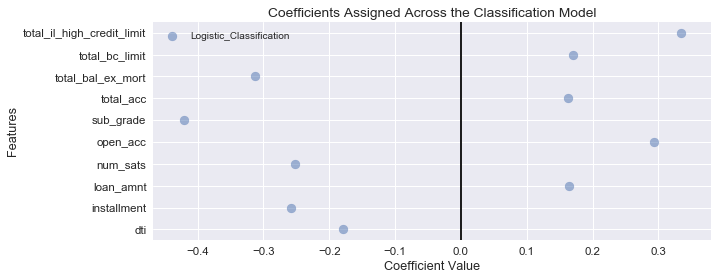

In [14]:
models = dict(Logistic_Classification=log_cls,)
coefs1 = plot_coefficients(X_train_scaled, models=models, thresh=(0.15,2), title='Classification Model')

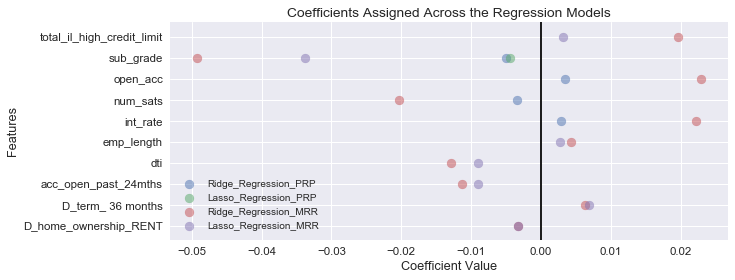

In [15]:
models = dict(Ridge_Regression_PRP=ridge_reg_PRP,
              Lasso_Regression_PRP=lasso_reg_PRP,
              Ridge_Regression_MRR=ridge_reg_MRR,
              Lasso_Regression_MRR=lasso_reg_MRR)
coefs2 = plot_coefficients(X_train_scaled, models=models, thresh=(0.0025,3), title='Regression Models')

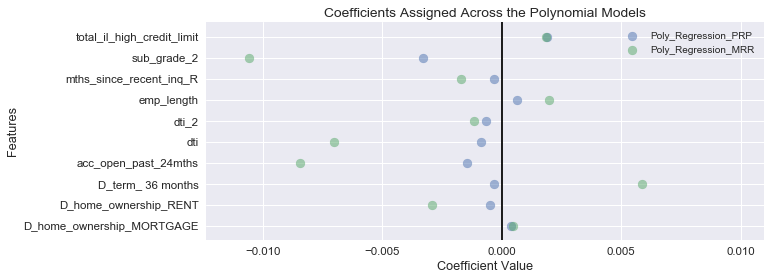

In [16]:
models = dict(
          Poly_Regression_PRP=lasso_reg2_PRP,
          Poly_Regression_MRR=lasso_reg2_MRR)
coefs3 = plot_coefficients(X_train_scaled_2, models=models, thresh=(0.0003,3), title='Polynomial Models')

## 2. Key Variables Driving Investment Decisions

The modeling has revealed key variables that should power the investment decisions: those which have significant coefficients across the distinct classification and regression models. These form the subset for our investment strategy formulation. This will aid interpretation and understanding for the investor at the loss of minimal investment efficacy. 

**Top 10 Key Variables**:

In [17]:
key_variables = coefs2['coefs'].sort_values().reset_index(drop=True)
key_variables.name = 'key_variables'
X_train_key = X_train_scaled[key_variables]
print(key_variables)

0         D_home_ownership_RENT
1             D_term_ 36 months
2          acc_open_past_24mths
3                           dti
4                    emp_length
5                      int_rate
6                      num_sats
7                      open_acc
8                     sub_grade
9    total_il_high_credit_limit
Name: key_variables, dtype: object


With the key variables established, we examine decision tree and random forest analysis on this key subset to establish the investment strategy. We focus on the most comprehensive outcome feature of `OUT_Monthly_Rate_Of_Return` since this feature takes into account the total amount repeiad with interest for the effective term of the loan. We visualize both a larger tree (for completeness and demonstrative purposes) and a simplified tree. 

In [18]:
keydecisiontree = DecisionTreeRegressor(random_state=0, 
                                     max_depth=10, 
                                     min_samples_split=.05)
keydecisiontree.fit(X_train_key, OUT_Monthly_Rate_Of_Return_train)
display(Markdown('**FULL Key Feaure Decision Tree**:'))
print(keydecisiontree)
graph = Source(export_graphviz(keydecisiontree, 
                               feature_names=X_train_key.columns,
                               out_file=None, 
                               filled = True))
display(SVG(graph.pipe(format='svg')))
print()

**FULL Key Feaure Decision Tree**:

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=0.05, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')


NameError: name 'Source' is not defined

In [ ]:
keydecisiontree = DecisionTreeRegressor(random_state=0, 
                                     max_depth=10, 
                                     min_samples_split=.05,
                                     max_leaf_nodes=10)
keydecisiontree.fit(X_train_key, OUT_Monthly_Rate_Of_Return_train)
display(Markdown('**SIMPLIFIED Key Feature Decision Tree**:'))
print(keydecisiontree)
graph = Source(export_graphviz(keydecisiontree, 
                               feature_names=X_train_key.columns,
                               out_file=None, 
                               filled = True))
display(SVG(graph.pipe(format='svg')))
print()

In [ ]:
keyrandomforest = RandomForestRegressor(n_estimators=10)
keyrandomforest.fit(X_train_key, OUT_Monthly_Rate_Of_Return_train)
display(Markdown('**Key Feature Random Forest**:'))
print(keyrandomforest)
importances = keyrandomforest.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature Importance of Key Features")
plt.bar(range(X_train_key.shape[1]), importances[indices])
plt.xticks(range(X_train_key.shape[1]), X_train_key.columns, rotation=90)
plt.show()

## 3. Investment Strategy

Based on the completed analysis, we postulate the following simple investment strategy to only invest in loans that meet the following criteria. To reduce risk and get the full benefit of diversification, we recommended that the mimimun qualifying investment should be made across as many qualifying loans as possible.

#### Non-Renter

Only invest in applications from non-renters.

In [19]:
non_renters = (ls['D_home_ownership_RENT'] == 0)

#### Shorter Term

Only invest in applications with term of 36 months.

In [20]:
short_term = (ls['D_term_ 36 months'] == 1)

#### Few Recent Accounts Opened

Only invest in applications from borrowers with less than 4 accounts opened in the last 24 months.

In [21]:
few_recent_accounts = (ls['acc_open_past_24mths'] < 4)

#### Low Debt-to-Income Ratio

Only invest in applications from borrowers with debt-to-equity ratios of less than 20%.

In [22]:
low_dti = (ls['dti'] < 20)

#### Solidly Employed

Only invest in applications from borrowers who have been employed over 5 years.

In [23]:
solid_emp = (ls['emp_length'] > 5)

#### Low Grade

Only invest in loans of grade A, B, C or D

In [24]:
low_grade = (ls['sub_grade'] <= 20)

## 4. Predictive Quality of Strategy

In [25]:
strategy = non_renters & short_term & few_recent_accounts & low_dti & solid_emp & low_grade

In [26]:
ls[strategy]

,D_home_ownership_MORTGAGE,D_home_ownership_OTHER,D_home_ownership_OWN,D_home_ownership_RENT,D_purpose_car,D_purpose_credit_card,D_purpose_debt_consolidation,D_purpose_home_improvement,D_purpose_house,D_purpose_major_purchase,D_purpose_medical,D_purpose_moving,D_purpose_other,D_purpose_renewable_energy,D_purpose_small_business,D_purpose_vacation,D_purpose_wedding,D_term_ 36 months,D_term_ 60 months,D_verification_status_Not Verified,D_verification_status_Source Verified,D_verification_status_Verified,OUT_Class,OUT_Monthly_Rate_Of_Return,OUT_Principle_Repaid_Percentage,...,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec,pub_rec_bankruptcies,revol_bal,revol_util,sub_grade,tax_liens,tot_coll_amt,tot_cur_bal,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,total_rev_hi_lim
1005326,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0.003,1.000,...,10.000,12.000,5.000,12.000,0.000,0.000,0.000,1.000,12.000,96.000,42.900,0.000,0.000,12689.000,41.300,2.000,0.000,0.000,358595.000,393700.000,25.000,37191.000,29900.000,28000.000,30700.000
1006038,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0.005,1.000,...,6.000,10.000,5.000,13.000,0.000,0.000,0.000,0.000,13.000,100.000,75.000,0.000,0.000,18243.000,81.400,1.000,0.000,0.000,205734.000,295241.000,19.000,131423.000,20200.000,112591.000,22400.000
1006206,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0.004,1.000,...,12.000,19.000,2.000,14.000,0.000,0.000,0.000,2.000,14.000,96.900,20.000,0.000,0.000,7513.000,14.400,6.000,0.000,0.000,130182.000,197661.000,32.000,23537.000,31100.000,19900.000,52100.000
1006460,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0.003,1.000,...,12.000,17.000,9.000,15.000,0.000,0.000,0.000,1.000,15.000,100.000,20.000,0.000,0.000,42061.000,41.200,4.000,0.000,0.000,197609.000,266546.000,26.000,53191.000,93800.000,18292.000,102000.000
1006519,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0.008,1.000,...,7.000,14.000,4.000,8.000,0.000,0.000,0.000,0.000,8.000,100.000,100.000,0.000,0.000,18648.000,80.700,12.000,0.000,2530.000,25962.000,58904.000,19.000,25962.000,14500.000,35804.000,23100.000
1006562,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0.003,1.000,...,5.000,9.000,4.000,9.000,0.000,0.000,0.000,1.000,9.000,93.300,0.000,0.000,0.000,12633.000,35.800,3.000,0.000,0.000,436447.000,478162.000,15.000,61086.000,29300.000,39027.000,35300.000
1006680,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0.006,1.000,...,5.000,7.000,4.000,10.000,0.000,0.000,1.000,2.000,10.000,50.000,33.300,0.000,0.000,4134.000,14.400,9.000,0.000,0.000,10989.000,53577.000,14.000,10989.000,28100.000,24877.000,28700.000
1006835,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0.003,1.000,...,8.000,12.000,8.000,11.000,0.000,0.000,0.000,0.000,11.000,86.400,33.300,0.000,0.000,38116.000,52.900,4.000,0.000,0.000,381561.000,482818.000,22.000,42654.000,67500.000,0.000,72100.000
1006953,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0.003,1.000,...,5.000,16.000,4.000,8.000,0.000,0.000,0.000,0.000,8.000,96.400,0.000,0.000,0.000,16259.000,46.600,1.000,0.000,0.000,162442.000,229008.000,28.000,42922.000,9500.000,63108.000,34900.000
1007061,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0.003,1.000,...,4.000,6.000,4.000,6.000,0.000,0.000,0.000,0.000,6.000,100.000,25.000,0.000,0.000,18867.000,68.100,2.000,0.000,0.000,186620.000,208191.000,11.000,27976.000,27700.000,13571.000,27700.000


In [27]:
len_strategy = np.sum(strategy)
len_strategy

33059

In [29]:
random = np.random.choice(ls.index.values, size=len_strategy, replace=False)
outputs = ['OUT_Class', 'OUT_Principle_Repaid_Percentage', 'OUT_Monthly_Rate_Of_Return']

for i in range(3):
    mean_strategy = np.mean(ls[outputs[i]][strategy])
    mean_random = np.mean(ls[outputs[i]][random])
    
    print(outputs[i])
    print('\tmean strategy: {}, mean random: {}'.format(mean_strategy, mean_random))
    print()

OUT_Class
	mean strategy: 0.9249523579055627, mean random: 0.8639402280770743

OUT_Principle_Repaid_Percentage
	mean strategy: 0.9593472396238821, mean random: 0.9214089885235194

OUT_Monthly_Rate_Of_Return
	mean strategy: 0.0020641693670500837, mean random: -0.001140830338692547

